## Objective
#### To build a model for predicting fraudulent transactions for a financial company.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Reading Data

In [7]:
df = pd.read_csv('/content/drive/MyDrive/accre/Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Data Preprocessing

In [8]:
null_values = df.isnull().sum()

# Display the count of null values for each column
print("Null Values in Each Column:")
print(null_values)

Null Values in Each Column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


#### Luckily, we don't have null vlaues to deal with.
#### Check for outliers.

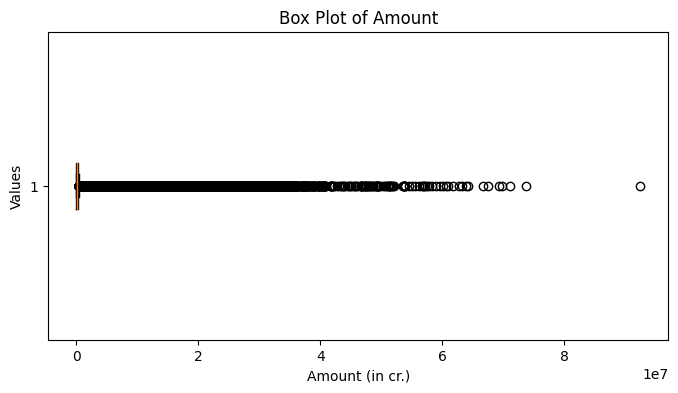

In [9]:
# Outliers by Boxplot
plt.figure(figsize= (8, 4))
plt.boxplot(df['amount'], vert= False)

plt.xlabel('Amount (in cr.)')
plt.ylabel('Values')
plt.title('Box Plot of Amount')

plt.show()

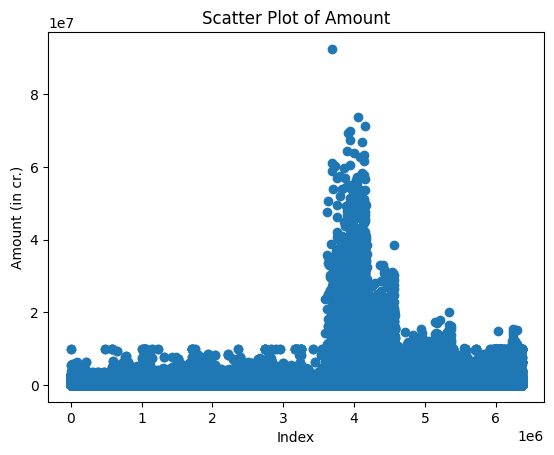

In [10]:
# Outliers by Scatter Plot
plt.scatter(df.index, df['amount'])
plt.xlabel('Index')
plt.ylabel('Amount (in cr.)')
plt.title('Scatter Plot of Amount')

plt.show()

In [11]:
# Outliers by IQR method
q1 = df['amount'].quantile(0.25)
q3 = df['amount'].quantile(0.75)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['amount'] < lower_bound) | (df['amount'] > upper_bound)]

print('Outliers :')
print(outliers)

Outliers :
         step      type      amount     nameOrig  oldbalanceOrg  \
85          1  TRANSFER  1505626.01   C926859124           0.00   
86          1  TRANSFER   554026.99  C1603696865           0.00   
88          1  TRANSFER   761507.39   C412788346           0.00   
89          1  TRANSFER  1429051.47  C1520267010           0.00   
93          1  TRANSFER   583848.46  C1839168128           0.00   
...       ...       ...         ...          ...            ...   
6362613   743  CASH_OUT  1258818.82  C1436118706     1258818.82   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
85                  0.0   C665576141        29031.00      5515763.34        0   
86                  0.

#### Total 338078 outliers

In [12]:
# outliers that are fraud
print(len(outliers[outliers.isFraud == 1]))

3854


#### Out of 338078 outliers, 3854 outliers which are actually found to be fraud.
#### Thus, we just can't drop them as it will make the dataset biased as we already have low weightage of fraud over not fraud.
#### For now, lets keep the outliers if model shows low accuracy then we can tune these outliers while keeping the fraud ones.

#### Drop the column nameOrig and nameDest as they don't play crucial role and create an error during calculating VIF(non-numerical).
#### Otherwise we have to tokenize them via NLP procedure.

In [13]:
df.drop(columns = ['nameOrig', 'nameDest'], axis = 1, inplace = True)
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


## EDA / Visualization

In [14]:
legit_transac = len(df[df['isFraud'] == 0])
fraud_transac = len(df[df['isFraud'] == 1])

legit_transac_percent = (legit_transac / (legit_transac + fraud_transac))*100
fraud_transac_percent = (fraud_transac / (legit_transac + fraud_transac))*100

print('Total legit transactions : ', legit_transac)
print('Total fraud transactions : ', fraud_transac)
print("Percentage of Legit transactions : ", legit_transac_percent)
print("Percentage of Fraud transactions : ", fraud_transac_percent)


Total legit transactions :  6354407
Total fraud transactions :  8213
Percentage of Legit transactions :  99.87091795518198
Percentage of Fraud transactions :  0.12908204481801522


([<matplotlib.patches.Wedge at 0x7ac8a23eba30>,
 [Text(-1.099990955625572, 0.004460666087110192, ''),
  Text(1.0999909559371663, -0.004460589247970448, '')],
 [Text(-0.5999950667048575, 0.002433090592969195, '99.8709%'),
  Text(0.599995066874818, -0.002433048680711153, '0.1291%')])

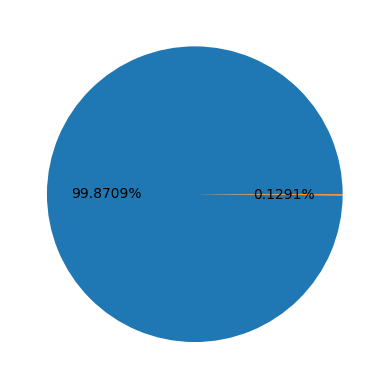

In [15]:
plt.pie(df['isFraud'].value_counts(), autopct='%.4f%%')

#### Here, we can see that less than 1% are fraud transaction which are so less in number that makes the dataset imballanced.

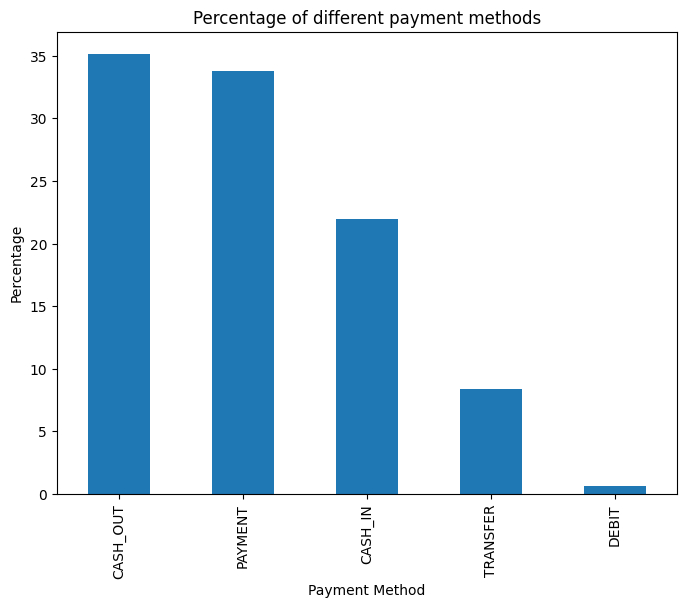

In [16]:
# Payment types
pay_count = df['type'].value_counts()
pay_percentage = (pay_count / pay_count.sum())*100

plt.figure(figsize=(8, 6))
pay_percentage.plot(kind = 'bar')

plt.xlabel('Payment Method')
plt.ylabel('Percentage')
plt.title('Percentage of different payment methods')
plt.show()

#### It shows that most of the payments are done through CASH_OUT and Payment method.

CASH_OUT    50.11567
TRANSFER    49.88433
Name: type, dtype: float64


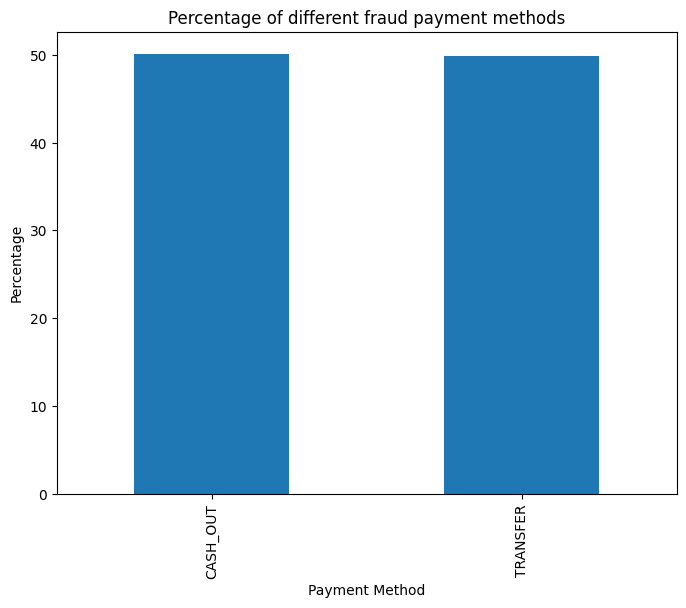

In [17]:
fraud_df = df[df['isFraud'] == 1]
legit_df = df[df['isFraud'] == 0]

pay_count_fraud = fraud_df['type'].value_counts()
pay_percentage_fraud = (pay_count_fraud/pay_count_fraud.sum())*100

print(pay_percentage_fraud)

plt.figure(figsize=(8, 6))
pay_percentage_fraud.plot(kind = 'bar')

plt.xlabel("Payment Method")
plt.ylabel("Percentage")
plt.title("Percentage of different fraud payment methods")

plt.show()


# work on cash-out and tranfer to reduce fraud

#### The most of fraud transactions are found in CASH_OUT and Transfer method.
#### They both together share nearly 50-50% of weightage of fraud transactions
#### Company has to take care of these two payment methods more seriously then others to avoid future fraud transactions.

#### Performing Label Encoding for Payment type

In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['type'] = label_encoder.fit_transform(df['type'])

df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0,0


#### Multicolinearity

<Axes: >

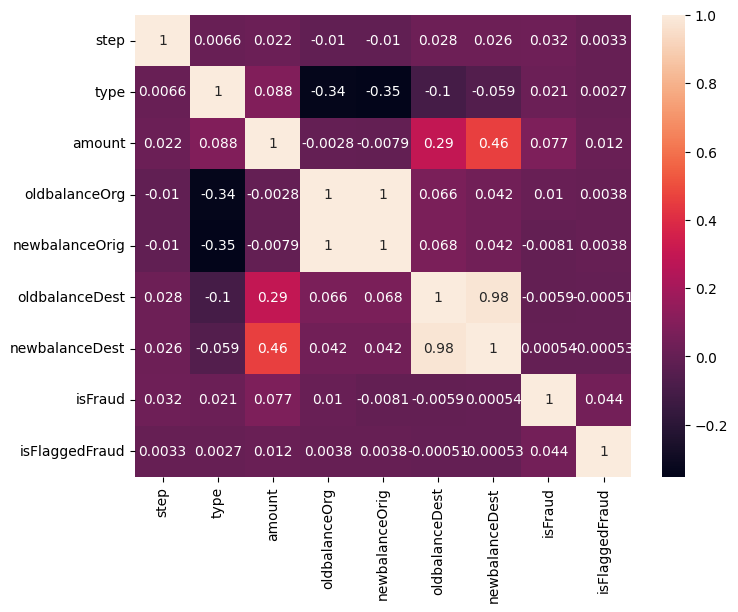

In [19]:
import seaborn as sns
corr = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot = True)

#### Columns like New_Balance_Org shows +ve correlation with Old_Balance_Org and New_Balance_Dest shows +ve correlation with Old_Balance_Dest.
#### By using the method of **variance_inflation_factor** where we usually drop the features with vif > 5.
#### This resolves the problem of multicollinearity.

In [20]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor


def calc_vif(df):
    vif = pd.DataFrame()
    vif['variables'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return vif

calc_vif(df)

,variables,VIF
0,step,2.250166
1,type,2.085348
2,amount,4.083184
3,oldbalanceOrg,564.439294
4,newbalanceOrig,568.748454
5,oldbalanceDest,73.127671
6,newbalanceDest,84.820467
7,isFraud,1.194160
8,isFlaggedFraud,1.002565


#### Combining the columns new_balance_org, old_balance_org and new_balance_dest, old_balance_dest by subtracting them.
#### It will left us with amount each transaction made from one account to another.

In [21]:
# combine them to new feature we can't just drop them
df['Amount_Org'] = df.apply(lambda x : x['oldbalanceOrg'] - x['newbalanceOrig'], axis  = 1)
df['Amount_Dest'] = df.apply(lambda x : x['oldbalanceDest'] - x['newbalanceDest'], axis  = 1)
df.drop(columns=['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis = 1, inplace = True)

calc_vif(df)

,variables,VIF
0,step,2.089916
1,type,2.039328
2,amount,3.883383
3,isFraud,1.187909
4,isFlaggedFraud,1.002535
5,Amount_Org,1.293306
6,Amount_Dest,3.774030


<Axes: >

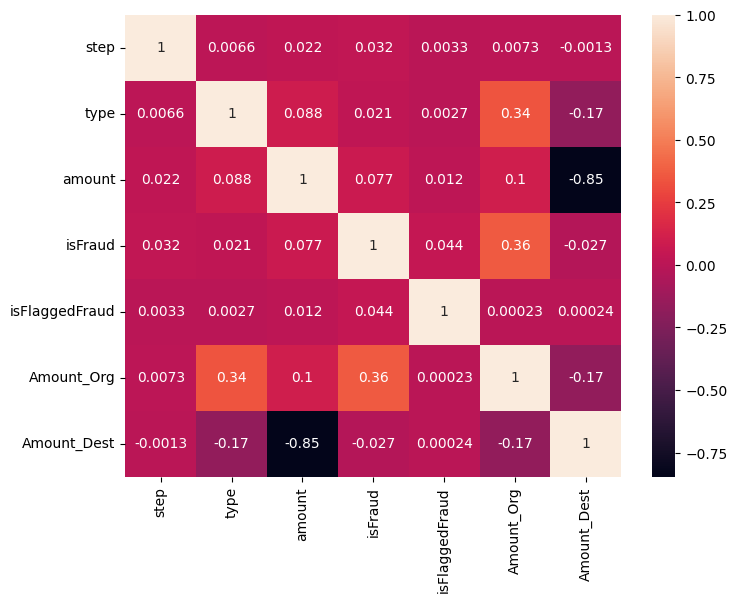

In [22]:
corr = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True)

In [23]:
df.head()

,step,type,amount,isFraud,isFlaggedFraud,Amount_Org,Amount_Dest
0,1,3,9839.64,0,0,9839.64,0.0
1,1,3,1864.28,0,0,1864.28,0.0
2,1,4,181.00,1,0,181.00,0.0
3,1,1,181.00,1,0,181.00,21182.0
4,1,3,11668.14,0,0,11668.14,0.0


#### Normalization of feautures

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

new_df = df.copy()
new_df['Norm_step'] = scaler.fit_transform(df['step'].values.reshape(-1, 1))
new_df['Norm_type'] = scaler.fit_transform(df['type'].values.reshape(-1, 1))
new_df['Norm_amount'] = scaler.fit_transform(df['amount'].values.reshape(-1, 1))
new_df['Norm_Amount_Org'] = scaler.fit_transform(df['Amount_Org'].values.reshape(-1, 1))
new_df['Norm_Amount_Dest'] = scaler.fit_transform(df['Amount_Dest'].values.reshape(-1, 1))
new_df['target'] = df['isFraud']

# Dropping the columns
new_df.drop(['step', 'type', 'amount', 'isFlaggedFraud', 'Amount_Org', 'Amount_Dest', 'isFraud'], axis = 1, inplace = True)


new_df.head()


,Norm_step,Norm_type,Norm_amount,Norm_Amount_Org,Norm_Amount_Dest,target
0,-1.703042,0.952399,-0.281560,0.211876,0.152896,0
1,-1.703042,0.952399,-0.294767,0.157490,0.152896,0
2,-1.703042,1.693076,-0.297555,0.146011,0.152896,1
3,-1.703042,-0.528954,-0.297555,0.146011,0.178952,1
4,-1.703042,0.952399,-0.278532,0.224345,0.152896,0


## Model Building

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc

#### Train Test Split

In [27]:
X = new_df.drop('target', axis=1)
Y = new_df['target']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2, random_state=42)

print("Shape of X_train : ", X_train.shape)
print("Shape of X_test : ", X_test.shape)

Shape of X_train :  (5090096, 5)
Shape of X_test :  (1272524, 5)


In [28]:
#ROC Plot
def plot_roc(y_test, probs):
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    print("ROC AUC=$0.2f"%roc_auc)
    plt.plot(fpr, tpr, label = 'AUC=%0.2f'%roc_auc,color='darkorange')
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'b--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

#### 1. Logistic Regression

In [29]:
lr = LogisticRegression(C=0.001, penalty='l2')

lr.fit(X_train, Y_train)

y_pred = lr.predict(X_test)


Logistic Regression Accuracy: 99.91%
[[1270816      88]
 [   1002     618]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.88      0.38      0.53      1620

    accuracy                           1.00   1272524
   macro avg       0.94      0.69      0.77   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC AUC=$0.2f


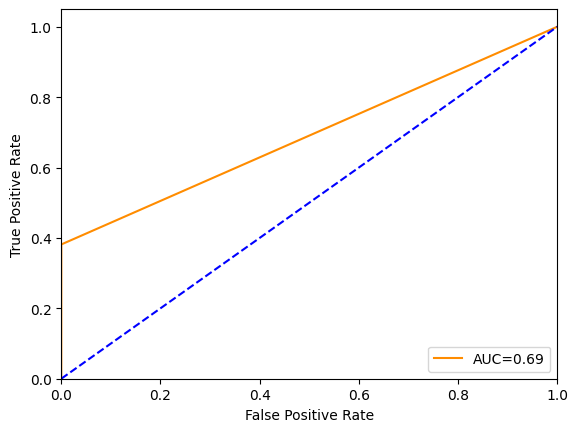

In [30]:
print("Logistic Regression Accuracy: {:.2f}%".format(lr.score(X_test, Y_test) * 100))
# pred = svm_model.predict(X_test)
print(confusion_matrix(Y_test,y_pred))
print(classification_report(Y_test, y_pred))


plot_roc(Y_test,y_pred)

#### 2. Random Forest

In [31]:
rf =  RandomForestClassifier(n_estimators=100)

rf.fit(X_train, Y_train)

y_pred = rf.predict(X_test)

Random Forest Accuracy: 99.97%
[[1270856      48]
 [    394    1226]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.96      0.76      0.85      1620

    accuracy                           1.00   1272524
   macro avg       0.98      0.88      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC AUC=$0.2f


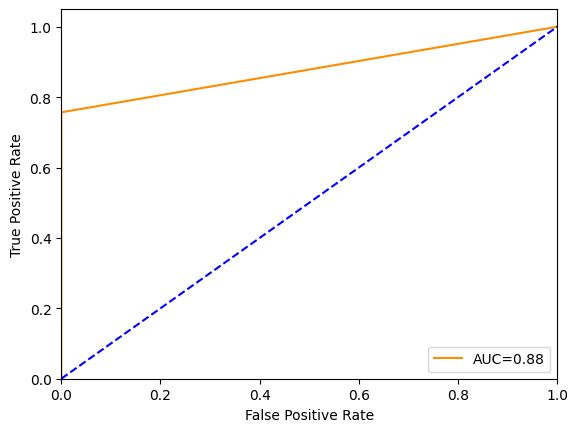

In [32]:
print("Random Forest Accuracy: {:.2f}%".format(rf.score(X_test, Y_test) * 100))
# pred = svm_model.predict(X_test)
print(confusion_matrix(Y_test,y_pred))
print(classification_report(Y_test, y_pred))


plot_roc(Y_test,y_pred)

## Model Evaluation
#### All the models gives 99% accuracy but since the dataset is imabalanced we can't totally relly on accuracy only.
#### In our case, we can't let a fraud transaction slip out of our hands as it's crucial. But, if a non fraud transaction is classified as fraud then we can cross check it.
#### Thus, we must choose the model  which shows less **Recall** or **False Negative**.

## Conclusion
#### Random Forest suits well for this binary classification because it gives better **Recall** accuracy then LR model.

# Visit Github repository for detailed documentation and answers to the questions asked in Task file -
<a href = "https://github.com/who-deepanshu/isFraud_detection">Github Repository Link....<a/>